In [1]:
# Basics
import pandas as pd
import numpy as np
import pickle

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from model_evaluation import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve)

In [2]:
raw_df = pd.read_csv('train.csv')

In [3]:
# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['label'].apply(lambda x: 1 if x == 1 else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

# Create end timestamp
target_date = pd.Timestamp('2020-12-31', tz='UTC')

# Calculate the difference in days between the 'created_at' and 'target_date' columns and create a new column called 'account_age_days'
raw_df['account_age_days'] = (target_date - raw_df['created_at']).dt.days + 1

# Calculate the number of tweets posted per day.
raw_df['average_tweets_per_day'] = raw_df['total_tweets'] / raw_df['account_age_days'] 

In [4]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'location', 'geo_enabled', 'lang', 
             'default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 
             'statuses_count', 'average_tweets_per_day', 'account_age_days']]

In [5]:
del raw_df

In [6]:
# Log transformations for highly skewed data
df.loc[:, 'friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df.loc[:, 'followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df.loc[:, 'favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df.loc[:, 'avg_daily_tweets_log'] = np.round(np.log(1 + df['average_tweets_per_day']), 3)

# Possible interactive features
df.loc[:, 'network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df.loc[:, 'tweet_to_followers'] = np.round(np.log(1 + df['statuses_count']) * np.log(1 + df['followers_count']), 3)

# Log-transformed daily acquisition metrics for distribution plots
df.loc[:, 'follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df.loc[:, 'friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df.loc[:, 'favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)


In [7]:
df.head()

,bot,screen_name,created_at,hour_created,verified,location,geo_enabled,lang,default_profile,default_profile_image,...,account_age_days,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,0,SHAQ,2008-11-18 10:27:25+00:00,10,1,"Orlando, FL",1,NaN,0,0,...,4426,6.541,16.547,4.963,0.044,108.234,152.064,8.152,0.145,0.145
1,1,JenniferFishpaw,2020-08-23 07:35:11+00:00,7,0,NaN,0,NaN,1,0,...,130,3.807,0.000,2.079,0.000,0.000,0.000,0.000,0.292,0.292
2,0,parscale,2008-11-27 18:47:32+00:00,18,1,Florida,1,NaN,0,0,...,4417,6.165,13.545,6.861,0.044,83.505,116.701,5.157,0.102,0.102
3,0,FOX13News,2008-08-06 15:12:10+00:00,15,1,"Tampa, FL",1,NaN,0,0,...,4530,8.477,12.700,7.989,0.043,107.658,154.551,4.295,0.723,0.723
4,1,VonteThePlugNC,2013-08-10 03:25:35+00:00,3,0,"Jacksonville Beach, FL",0,NaN,1,0,...,2700,6.474,9.497,6.593,0.032,61.484,44.110,1.781,0.215,0.215


In [8]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            #'lang',
            #'location',
            #'geo_enabled', 
            #'default_profile', 
            #'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [10]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [11]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.78564 +- 0.006342
Precision: 0.76514 +- 0.015952
Recall:    0.89188 +- 0.011863
F1 Score:  0.82345 +- 0.006178
ROC AUC:   0.81771 +- 0.016721

Model: LogisticRegression()
------------------------------
Accuracy:  0.81377 +- 0.014536
Precision: 0.75158 +- 0.019128
Recall:    0.99786 +- 0.001547
F1 Score:  0.85724 +- 0.012239
ROC AUC:   0.81970 +- 0.009401



In [12]:
# Models that don't require scaling
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, bnb, mnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [13]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.64187 +- 0.012559
Precision: 0.61341 +- 0.012205
Recall:    0.97752 +- 0.004212
F1 Score:  0.75373 +- 0.009486
ROC AUC:   0.71195 +- 0.009114

Model: BernoulliNB()
------------------------------
Accuracy:  0.81550 +- 0.007063
Precision: 0.75397 +- 0.010645
Recall:    0.99603 +- 0.002353
F1 Score:  0.85820 +- 0.006266
ROC AUC:   0.79690 +- 0.006604

Model: MultinomialNB()
------------------------------
Accuracy:  0.70866 +- 0.009702
Precision: 0.66960 +- 0.012531
Recall:    0.94898 +- 0.005087
F1 Score:  0.78507 +- 0.007234
ROC AUC:   0.67633 +- 0.007396

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.72368 +- 0.010843
Precision: 0.75887 +- 0.010427
Recall:    0.74385 +- 0.021377
F1 Score:  0.75106 +- 0.011224
ROC AUC:   0.72114 +- 0.009678

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.80808 +- 0.007148
Precision: 0.76588 +- 0.010926
Recall:    0.94739 +- 0.001945


Average AUC Score: 0.8250 +- 0.013102


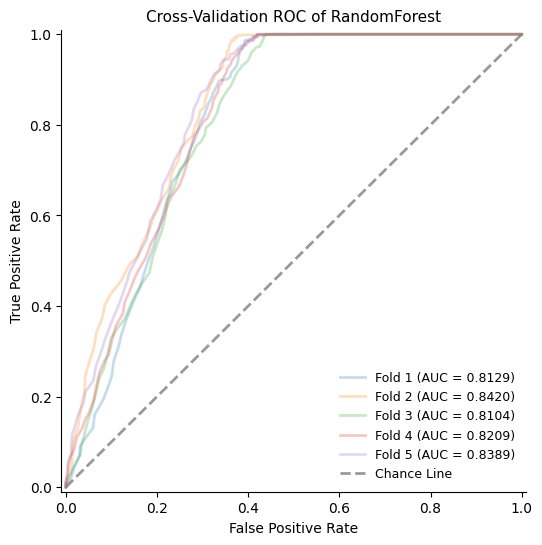

In [14]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.7648 +- 0.016778
Average Recall Score: 0.9435 +- 0.011872


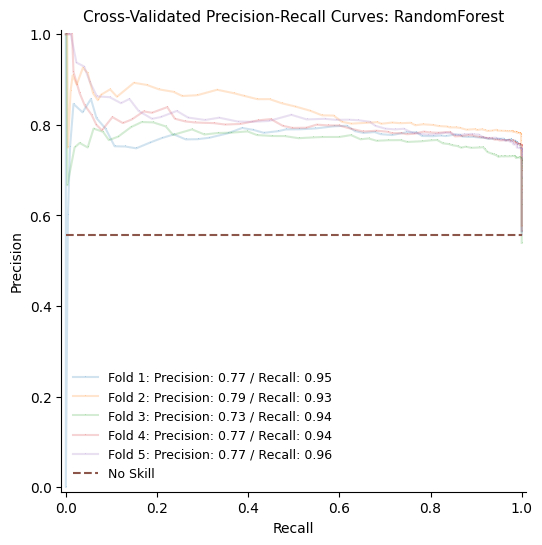

In [15]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.8208 +- 0.007441


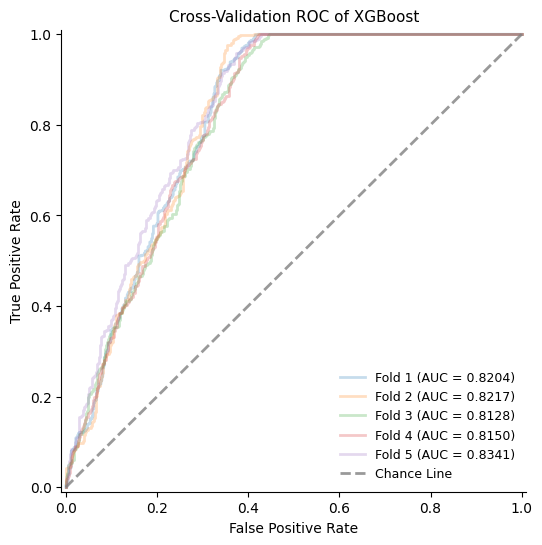

In [16]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.7667 +- 0.015219
Average Recall Score: 0.9078 +- 0.010046


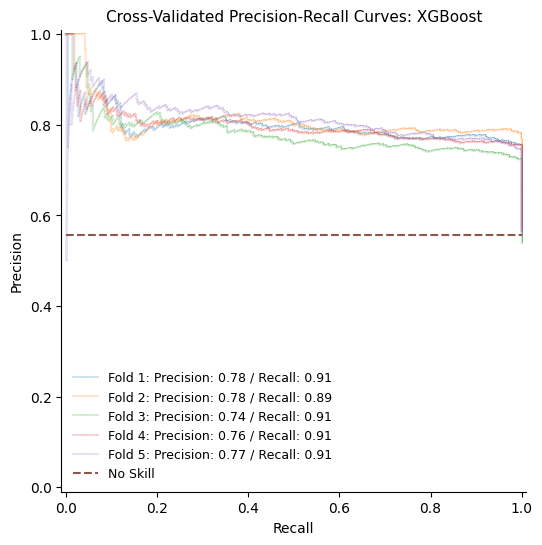

In [17]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

In [18]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  4646
Number of humans:  3632
Bots / Total %: 56.12


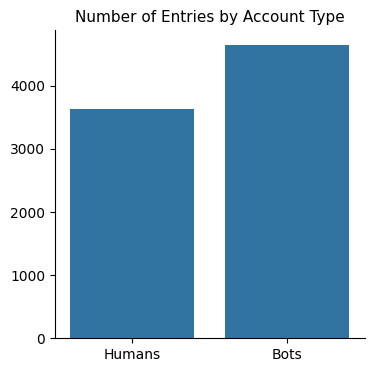

In [19]:
types = ['Humans', 'Bots']
counts = [num_humans, num_bots]

plt.figure(figsize=(4, 4))
sns.barplot(x = types, y = counts)
plt.title("Number of Entries by Account Type", fontsize=11)
sns.despine();

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

In [21]:
forest = RandomForestClassifier(class_weight='balanced')

forest.fit(X_train, y_train)
preds = forest.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8033
Precision: 0.7651
Recall:    0.9359
F1 Score:  0.8419

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       638
           1       0.77      0.94      0.84       811

    accuracy                           0.80      1449
   macro avg       0.83      0.79      0.79      1449
weighted avg       0.82      0.80      0.80      1449




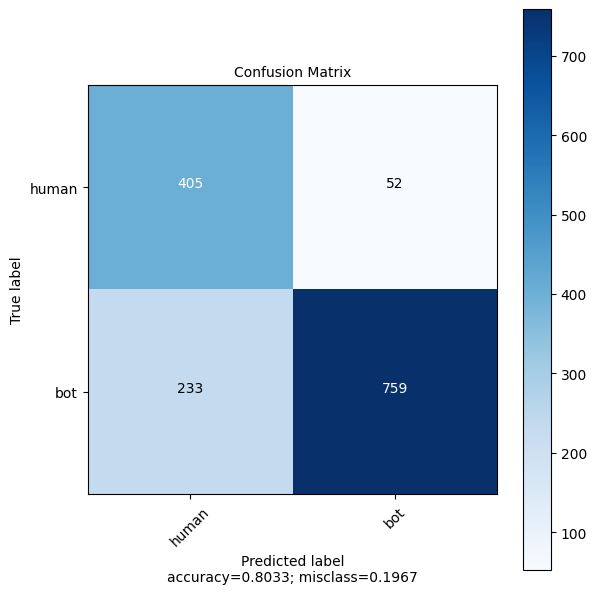

In [22]:
metrics_report(preds, y_val)

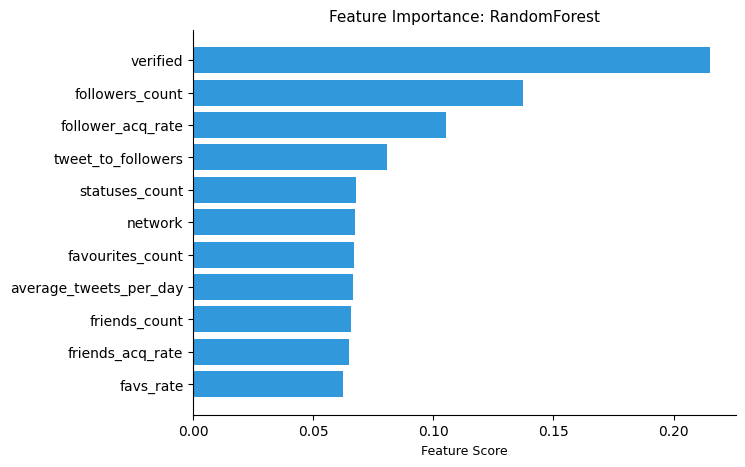

In [23]:
plot_feature_importance(forest, features, model_alias='RandomForest')

# XGBoost

In [25]:
# For XGBoost
estimate = num_humans/num_bots
estimate

0.7817477399913905

In [26]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.7798
Precision: 0.7727
Recall:    0.8594
F1 Score:  0.8138

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       638
           1       0.77      0.86      0.81       811

    accuracy                           0.78      1449
   macro avg       0.78      0.77      0.77      1449
weighted avg       0.78      0.78      0.78      1449




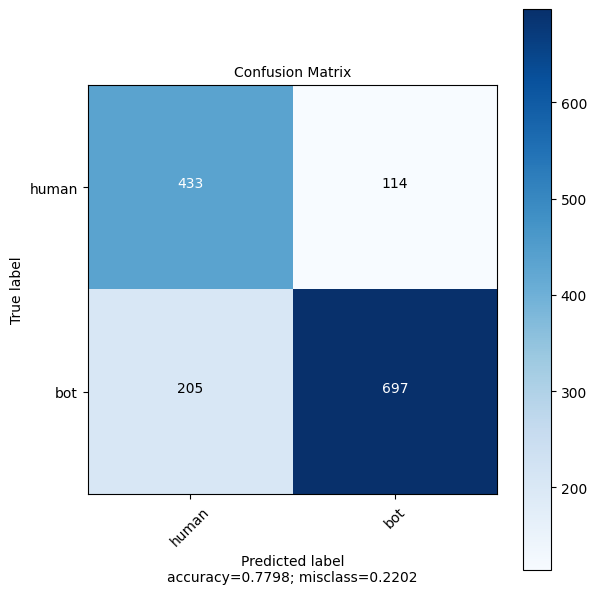

In [27]:
metrics_report(preds, y_val)

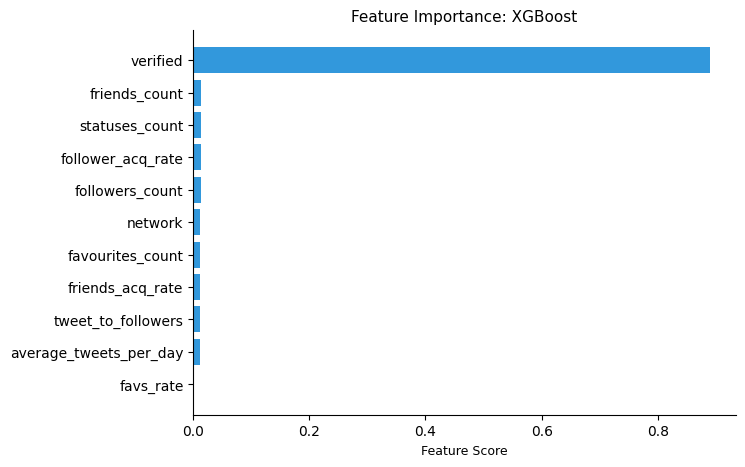

In [28]:
plot_feature_importance(xgb, features, model_alias='XGBoost')

# Continued Tuning and Feature Selection

In [29]:
df.head(3)

,bot,screen_name,created_at,hour_created,verified,location,geo_enabled,lang,default_profile,default_profile_image,...,account_age_days,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,0,SHAQ,2008-11-18 10:27:25+00:00,10,1,"Orlando, FL",1,NaN,0,0,...,4426,6.541,16.547,4.963,0.044,108.234,152.064,8.152,0.145,0.145
1,1,JenniferFishpaw,2020-08-23 07:35:11+00:00,7,0,NaN,0,NaN,1,0,...,130,3.807,0.000,2.079,0.000,0.000,0.000,0.000,0.292,0.292
2,0,parscale,2008-11-27 18:47:32+00:00,18,1,Florida,1,NaN,0,0,...,4417,6.165,13.545,6.861,0.044,83.505,116.701,5.157,0.102,0.102


In [30]:
features = ['verified', 
            'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

# Finding the best XGBoost Model

In [31]:
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

model_list = [xgb]

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)
------------------------------
Accuracy:  0.81101 +- 0.009097
Precision: 0.76180 +- 0.014243
Recall:    0.96471 +- 0.007901
F1 Score:  0.85122 +- 0.008200
ROC AUC:   0.82963 +- 0.010845



Average AUC Score: 0.8296 +- 0.010845


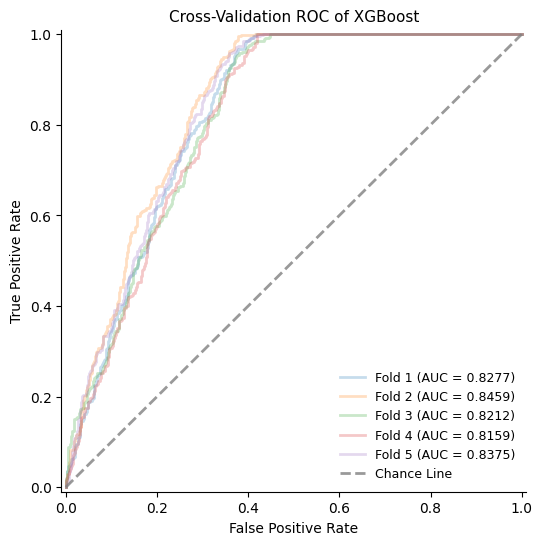

In [33]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.7618 +- 0.014243
Average Recall Score: 0.9647 +- 0.007901


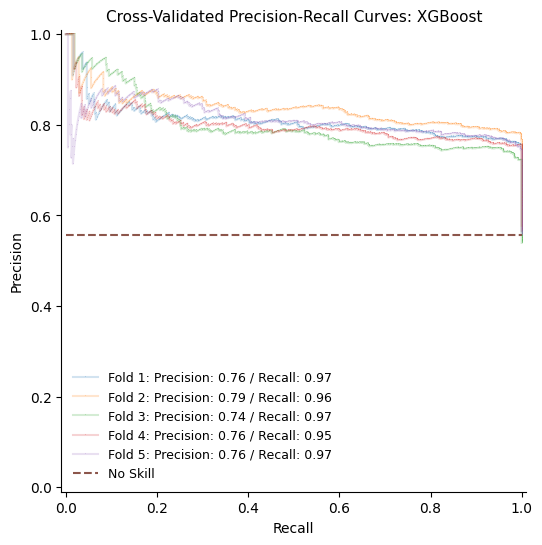

In [34]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

# Ensembling with VotingClassifier

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=1234)

In [36]:
forest = RandomForestClassifier(class_weight='balanced')
forest = forest.fit(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

xgb = xgb.fit(X_train, y_train)

In [37]:
models = [('forest', forest), ('xgb', xgb)]

voting_classifier = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

voting_classifier = voting_classifier.fit(X_train, y_train)

Classification Metrics Report
-----------------------------
Accuracy:  0.8068
Precision: 0.7578
Recall:    0.9586
F1 Score:  0.8464

              precision    recall  f1-score   support

           0       0.92      0.62      0.74       773
           1       0.76      0.96      0.85       966

    accuracy                           0.81      1739
   macro avg       0.84      0.79      0.79      1739
weighted avg       0.83      0.81      0.80      1739




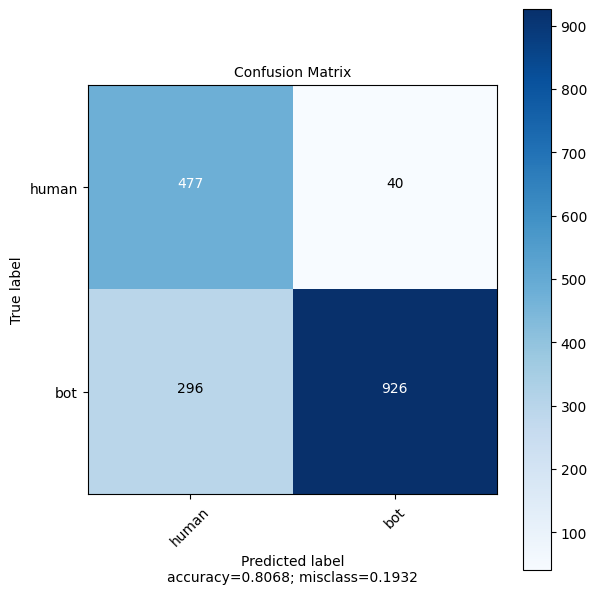

In [38]:
voting_classifier_prediction = voting_classifier.predict(X_val)

metrics_report(voting_classifier_prediction, y_val)

# Best Ensembling Model: Full Train & Test and Results

In [40]:
forest = RandomForestClassifier(class_weight='balanced')
forest = forest.fit(X, y)

xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

xgb = xgb.fit(X, y)

In [42]:
models = [('forest', forest), ('xgb', xgb)]

best_model = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

best_model = best_model.fit(X, y)

Classification Metrics Report
-----------------------------
Accuracy:  0.7987
Precision: 0.7468
Recall:    0.9714
F1 Score:  0.8444

              precision    recall  f1-score   support

           0       0.94      0.58      0.71      1087
           1       0.75      0.97      0.84      1397

    accuracy                           0.80      2484
   macro avg       0.84      0.77      0.78      2484
weighted avg       0.83      0.80      0.79      2484




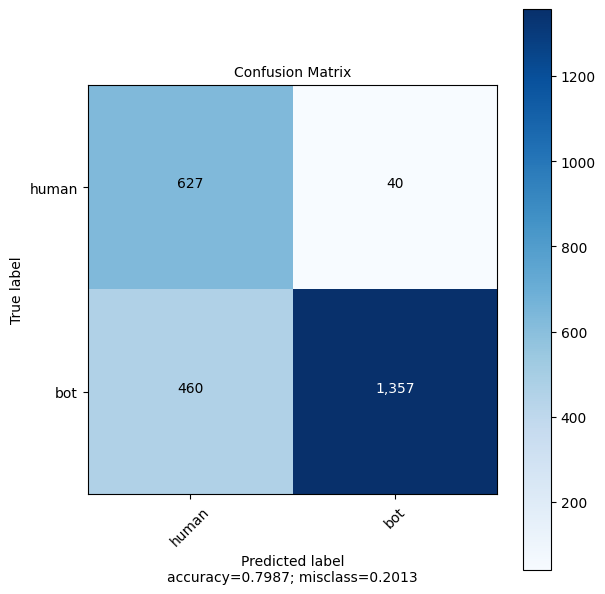

In [43]:
best_model_prediction = best_model.predict(X_test)

metrics_report(best_model_prediction, y_test)

ROC AUC score: 0.8191



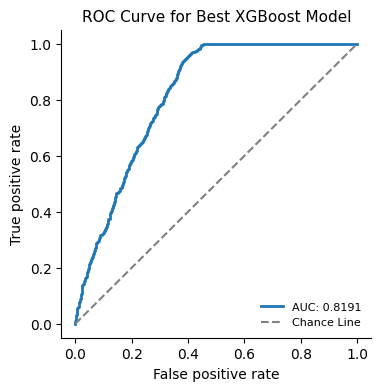

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

model_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr, tpr,lw=2, label=f'AUC: {model_auc:.4f}')
plt.plot([0,1],[0,1],c='grey',ls='--', label='Chance Line')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=10)
plt.ylabel('True positive rate', fontsize=10)
plt.title('ROC Curve for Best XGBoost Model', fontsize=11)
plt.legend(loc='lower right', prop={'size': 8}, frameon=False)
sns.despine()
print(f'ROC AUC score: {model_auc:.4f}')
print("")
plt.show();

Precision score: 0.7468
Rcall score: 0.9714



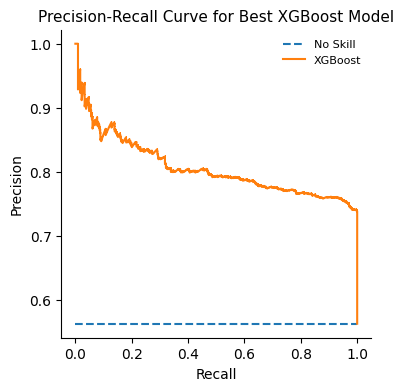

In [45]:
# Prec Recal Curve here

model_precision, model_recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(model_recall, model_precision, marker=',', label='XGBoost')
# axis labels
plt.title('Precision-Recall Curve for Best XGBoost Model', fontsize=11)
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
# show the legend
plt.legend(loc='upper right', prop={'size': 8}, frameon=False)
# show the plot
sns.despine()

pred = best_model.predict(X_test)
prec_score = precision_score(y_test, pred)
rec_score = recall_score(y_test, pred)

print(f'Precision score: {prec_score:.4f}')
print(f'Rcall score: {rec_score:.4f}')
print(""